In [1]:
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm


In [2]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_param=0.05, beta=3, gamma=0.001):
        super(SparseAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.sparsity_param = sparsity_param
        self.beta = beta
        self.gamma = gamma

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def kl_divergence(self, p_hat):
        p = self.sparsity_param
        kl = p * torch.log(p / p_hat) + (1 - p) * torch.log((1 - p) / (1 - p_hat))
        return torch.sum(kl)

    def loss_function(self, x, x_recon, encoded):
        # 重构损失
        reconstruction_loss = F.mse_loss(x_recon, x)

        # 稀疏性约束
        rho_hat = torch.mean(encoded, dim=0)
        kl_loss = self.kl_divergence(rho_hat)

        # L2正则化
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)

        total_loss = reconstruction_loss + self.beta * kl_loss + self.gamma * l2_loss
        return total_loss

In [3]:
class DTLModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[400, 50, 10], num_classes=10):
        super(DTLModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes

        # 三层SAE编码器
        self.sae1_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.Sigmoid()
        )
        self.sae2_encoder = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.Sigmoid()
        )
        self.sae3_encoder = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.Sigmoid()
        )

        # 分类器
        self.classifier = nn.Linear(hidden_dims[2], num_classes)

        # 预训练模型
        self.sae1 = SparseAutoencoder(input_dim, hidden_dims[0])
        self.sae2 = SparseAutoencoder(hidden_dims[0], hidden_dims[1])
        self.sae3 = SparseAutoencoder(hidden_dims[1], hidden_dims[2])

    def forward(self, x):
        # 前向传播
        x = self.sae1_encoder(x)
        x = self.sae2_encoder(x)
        features = self.sae3_encoder(x)
        output = self.classifier(features)
        return output, features

    def get_features(self, x):
        """获取特征表示"""
        x = self.sae1_encoder(x)
        x = self.sae2_encoder(x)
        features = self.sae3_encoder(x)
        return features

In [4]:
def maximum_mean_discrepancy(source_features, target_features):
    """计算最大均值差异(MMD)"""
    source_mean = torch.mean(source_features, dim=0)
    target_mean = torch.mean(target_features, dim=0)
    mmd = torch.sum((source_mean - target_mean) ** 2)
    return mmd


In [5]:
class BearingDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]



In [6]:
def load_bearing_data(data_path):
    """加载轴承数据并进行预处理"""
    datasets = {}

    # 定义故障类型和对应的文件名模式
    fault_patterns = {
        'N': ['N.mat'],
        'OF': ['OF.mat', 'OF (2).mat', 'OF (3).mat', 'OF (4).mat', 'OF (5).mat', 'OF (6).mat'],
        'IF': ['IF.mat', 'IF (2).mat', 'IF (3).mat', 'IF (4).mat'],
        'BF': ['BF.mat', 'BF (2).mat', 'BF (3).mat', 'BF (4).mat']
    }

    # 为每种故障类型分配标签
    fault_labels = {
        'N': 0,
        'OF': 1,
        'IF': 2,
        'BF': 3
    }

    for load_condition in ['0', '1', '2', '3']:
        load_data = []
        labels = []

        for fault_type, file_patterns in fault_patterns.items():
            label = fault_labels[fault_type]

            for file_pattern in file_patterns:
                # 查找匹配的文件
                search_pattern = os.path.join(data_path, load_condition, file_pattern)
                matching_files = glob.glob(search_pattern)

                if not matching_files:
                    print(f"Warning: No file found for pattern {search_pattern}")
                    continue

                for file_path in matching_files:
                    try:
                        # 加载.mat文件
                        data = sio.loadmat(file_path)

                        # 提取振动信号数据
                        vibration_data = None
                        for key in data.keys():
                            if not key.startswith('__') and isinstance(data[key], np.ndarray):
                                if data[key].size >= 4000:  # 确保数据足够长
                                    vibration_data = data[key].flatten()
                                    break

                        if vibration_data is None:
                            print(f"No suitable data found in {file_path}")
                            continue

                        # 数据分割 - 每个样本4000个点
                        num_samples = len(vibration_data) // 4000
                        for i in range(min(num_samples, 200)):  # 最多取200个样本
                            start_idx = i * 4000
                            end_idx = start_idx + 4000
                            sample = vibration_data[start_idx:end_idx]

                            if len(sample) == 4000:
                                load_data.append(sample)
                                labels.append(label)

                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")
                        continue

        if load_data:
            datasets[load_condition] = {
                'data': np.array(load_data),
                'labels': np.array(labels)
            }
            print(f"Load condition {load_condition}: {len(load_data)} samples, {len(np.unique(labels))} classes")
        else:
            print(f"Warning: No data found for load condition {load_condition}")

    return datasets

def compute_autocorrelation_power_spectrum(signals):
    """计算自相关功率谱特征"""
    print("Computing auto-correlation power spectrum...")
    spectra = []

    for signal in tqdm(signals):
        try:
            # 自相关计算
            autocorr = np.correlate(signal, signal, mode='full')
            autocorr = autocorr[len(autocorr)//2:]  # 取后半部分

            # 功率谱计算
            spectrum = np.abs(np.fft.fft(autocorr))
            spectrum = spectrum[:2001]  # 取前2001个点

            # 归一化
            if np.max(spectrum) > 0:
                spectrum = spectrum / np.max(spectrum)

            spectra.append(spectrum)
        except Exception as e:
            print(f"Error computing spectrum: {e}")
            continue

    return np.array(spectra)

def preprocess_data(datasets):
    """数据预处理"""
    processed_datasets = {}

    for load_condition, data_dict in datasets.items():
        # 计算自相关功率谱
        spectra = compute_autocorrelation_power_spectrum(data_dict['data'])

        # 数据标准化
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(spectra)

        processed_datasets[load_condition] = {
            'data': scaled_data,
            'labels': data_dict['labels'],
            'scaler': scaler
        }

        print(f"Processed load {load_condition}: {scaled_data.shape}")

    return processed_datasets



In [7]:
def pretrain_sae_layer(sae, dataloader, epochs=50, device='cuda'):
    """预训练单个SAE层"""
    optimizer = optim.Adam(sae.parameters(), lr=0.001)
    sae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_data, _ in dataloader:
            batch_data = batch_data.to(device)

            optimizer.zero_grad()
            x_recon, encoded = sae(batch_data)
            loss = sae.loss_function(batch_data, x_recon, encoded)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

def train_dtl_model(source_data, target_data, mu=0.5, device='cuda'):
    """训练DTL模型"""

    X_source = source_data['data']
    X_target = target_data['data']
    y_source = source_data['labels']

    # 创建数据集和数据加载器
    source_dataset = BearingDataset(X_source, y_source)
    source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)

    # 构建模型
    dtl_model = DTLModel(input_dim=2001, hidden_dims=[400, 50, 10], num_classes=4).to(device)

    # 预训练阶段
    print("Pre-training SAE layers...")

    # 组合源域和目标域数据用于预训练
    pretrain_data = np.vstack([X_source, X_target])
    pretrain_labels = np.zeros(len(pretrain_data))  # 无标签预训练

    pretrain_dataset = BearingDataset(pretrain_data, pretrain_labels)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)

    # 预训练第一层SAE
    print("Training SAE layer 1...")
    pretrain_sae_layer(dtl_model.sae1, pretrain_loader, epochs=200, device=device)

    # 更新第一层编码器权重
    dtl_model.sae1_encoder[0].weight.data = dtl_model.sae1.encoder[0].weight.data.clone()
    dtl_model.sae1_encoder[0].bias.data = dtl_model.sae1.encoder[0].bias.data.clone()

    # 获取第一层特征用于第二层预训练
    with torch.no_grad():
        features_layer1 = []
        for batch_data, _ in pretrain_loader:
            batch_data = batch_data.to(device)
            encoded1 = dtl_model.sae1_encoder(batch_data)
            features_layer1.append(encoded1.cpu().numpy())
        features_layer1 = np.vstack(features_layer1)

    layer1_dataset = BearingDataset(features_layer1, np.zeros(len(features_layer1)))
    layer1_loader = DataLoader(layer1_dataset, batch_size=32, shuffle=True)

    # 预训练第二层SAE
    print("Training SAE layer 2...")
    pretrain_sae_layer(dtl_model.sae2, layer1_loader, epochs=200, device=device)
    dtl_model.sae2_encoder[0].weight.data = dtl_model.sae2.encoder[0].weight.data.clone()
    dtl_model.sae2_encoder[0].bias.data = dtl_model.sae2.encoder[0].bias.data.clone()

    # 获取第二层特征用于第三层预训练
    with torch.no_grad():
        features_layer2 = []
        for batch_data, _ in layer1_loader:
            batch_data = batch_data.to(device)
            encoded2 = dtl_model.sae2_encoder(batch_data)
            features_layer2.append(encoded2.cpu().numpy())
        features_layer2 = np.vstack(features_layer2)

    layer2_dataset = BearingDataset(features_layer2, np.zeros(len(features_layer2)))
    layer2_loader = DataLoader(layer2_dataset, batch_size=32, shuffle=True)

    # 预训练第三层SAE
    print("Training SAE layer 3...")
    pretrain_sae_layer(dtl_model.sae3, layer2_loader, epochs=200, device=device)
    dtl_model.sae3_encoder[0].weight.data = dtl_model.sae3.encoder[0].weight.data.clone()
    dtl_model.sae3_encoder[0].bias.data = dtl_model.sae3.encoder[0].bias.data.clone()

    # 微调阶段
    print("Fine-tuning DTL model...")
    optimizer = optim.Adam(dtl_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []

    # 准备目标域数据用于MMD计算
    target_dataset = BearingDataset(X_target, np.zeros(len(X_target)))
    target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

    for epoch in range(200):
        dtl_model.train()
        total_loss = 0
        correct = 0
        total = 0

        # 同时遍历源域和目标域
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        num_batches = min(len(source_loader), len(target_loader))

        for batch_idx in range(num_batches):
            try:
                # 获取源域批次数据
                source_batch_data, source_batch_labels = next(source_iter)
                source_batch_data = source_batch_data.to(device)
                source_batch_labels = source_batch_labels.to(device)

                # 获取目标域批次数据
                target_batch_data, _ = next(target_iter)
                target_batch_data = target_batch_data.to(device)

                optimizer.zero_grad()

                # 源域前向传播
                source_outputs, source_features = dtl_model(source_batch_data)

                # 分类损失
                classification_loss = criterion(source_outputs, source_batch_labels)

                # 目标域特征提取
                target_features = dtl_model.get_features(target_batch_data)

                # MMD损失
                mmd_loss = maximum_mean_discrepancy(source_features, target_features)

                # 总损失
                loss = classification_loss + mu * mmd_loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(source_outputs.data, 1)
                total += source_batch_labels.size(0)
                correct += (predicted == source_batch_labels).sum().item()

            except StopIteration:
                break

        accuracy = 100 * correct / total if total > 0 else 0
        avg_loss = total_loss / num_batches if num_batches > 0 else 0

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/100], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return dtl_model, {'loss': train_losses, 'accuracy': train_accuracies}



In [8]:
def evaluate_model(model, test_data, device='cuda'):
    """评估模型"""
    model.eval()

    X_test = test_data['data']
    y_test = test_data['labels']

    test_dataset = BearingDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            outputs, _ = model(batch_data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, cm, all_predictions, all_labels, all_probabilities

def plot_training_history(history, task_name):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['loss'])
    ax1.set_title(f'{task_name} - Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history['accuracy'])
    ax2.set_title(f'{task_name} - Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{task_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, classes, task_name):
    """绘制混淆矩阵"""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {task_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 在矩阵中显示数值
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{task_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


Using device: cuda
Loading bearing data...
Load condition 0: 480 samples, 4 classes
Load condition 1: 540 samples, 4 classes
Load condition 2: 540 samples, 4 classes
Load condition 3: 481 samples, 4 classes
Preprocessing data...
Computing auto-correlation power spectrum...


100%|██████████| 480/480 [00:01<00:00, 442.95it/s]


Processed load 0: (480, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 540/540 [00:01<00:00, 436.26it/s]


Processed load 1: (540, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 540/540 [00:01<00:00, 440.35it/s]


Processed load 2: (540, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 481/481 [00:01<00:00, 438.72it/s]


Processed load 3: (481, 2001)

Training transfer task: 0 -> 1
Source domain 0: 480 samples
Target domain 1: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 141.2156
Epoch [20/200], Loss: 86.8519
Epoch [30/200], Loss: 76.6220
Epoch [40/200], Loss: 69.8513
Epoch [50/200], Loss: 68.8874
Epoch [60/200], Loss: 75.7321
Epoch [70/200], Loss: 67.3210
Epoch [80/200], Loss: 65.3450
Epoch [90/200], Loss: 70.3573
Epoch [100/200], Loss: 69.8427
Epoch [110/200], Loss: 68.1888
Epoch [120/200], Loss: 67.9893
Epoch [130/200], Loss: 66.0346
Epoch [140/200], Loss: 69.8161
Epoch [150/200], Loss: 68.2674
Epoch [160/200], Loss: 66.9343
Epoch [170/200], Loss: 67.6857
Epoch [180/200], Loss: 69.1447
Epoch [190/200], Loss: 66.2198
Epoch [200/200], Loss: 68.0774
Training SAE layer 2...
Epoch [10/200], Loss: 29.5882
Epoch [20/200], Loss: 17.1447
Epoch [30/200], Loss: 11.0257
Epoch [40/200], Loss: 7.3712
Epoch [50/200], Loss: 5.0969
Epoch [60/200], Loss: 3.5056
Epoch [70/200], 

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


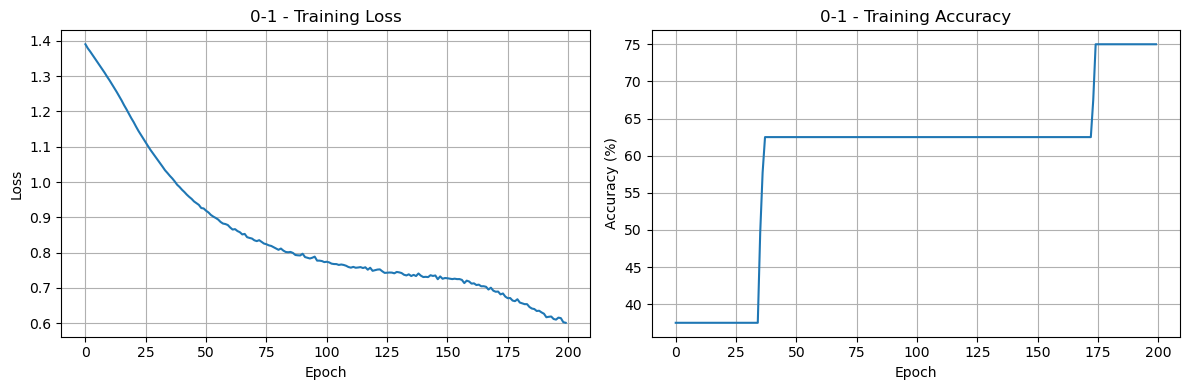

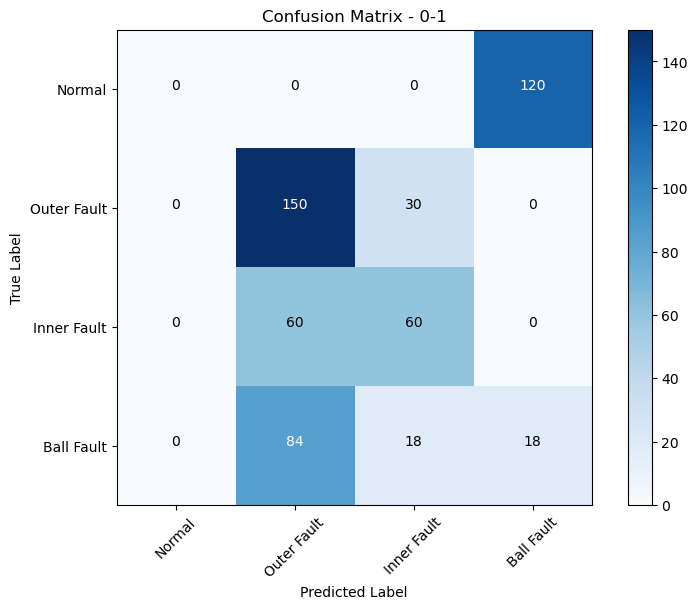


Training transfer task: 0 -> 2
Source domain 0: 480 samples
Target domain 2: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 148.8916
Epoch [20/200], Loss: 107.9058
Epoch [30/200], Loss: 101.9159
Epoch [40/200], Loss: 102.7857
Epoch [50/200], Loss: 97.3655
Epoch [60/200], Loss: 97.4254
Epoch [70/200], Loss: 93.5444
Epoch [80/200], Loss: 98.1514
Epoch [90/200], Loss: 93.5591
Epoch [100/200], Loss: 93.0012
Epoch [110/200], Loss: 96.7386
Epoch [120/200], Loss: 95.3931
Epoch [130/200], Loss: 91.4410
Epoch [140/200], Loss: 93.9751
Epoch [150/200], Loss: 101.7579
Epoch [160/200], Loss: 95.7085
Epoch [170/200], Loss: 91.4187
Epoch [180/200], Loss: 95.7767
Epoch [190/200], Loss: 91.0037
Epoch [200/200], Loss: 93.7356
Training SAE layer 2...
Epoch [10/200], Loss: 27.4431
Epoch [20/200], Loss: 18.7229
Epoch [30/200], Loss: 12.8411
Epoch [40/200], Loss: 8.7888
Epoch [50/200], Loss: 5.9774
Epoch [60/200], Loss: 4.0635
Epoch [70/200], Loss: 2.7051
Epoch [80/200

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


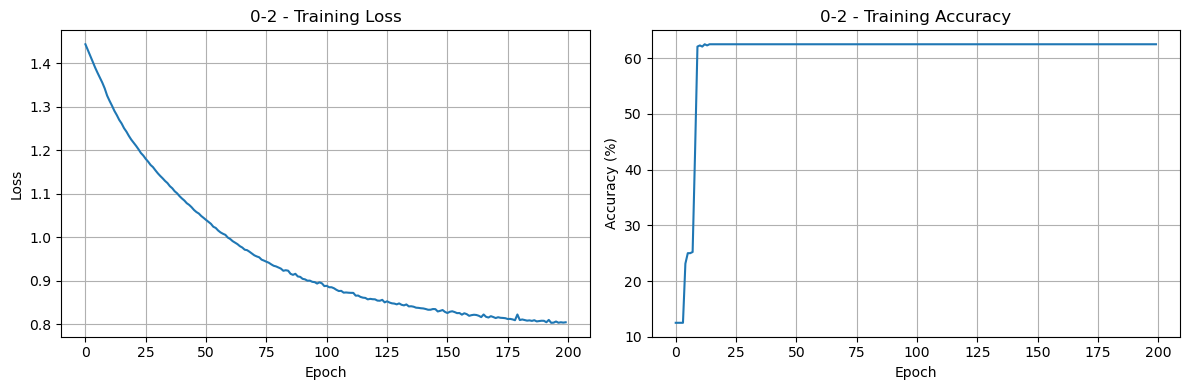

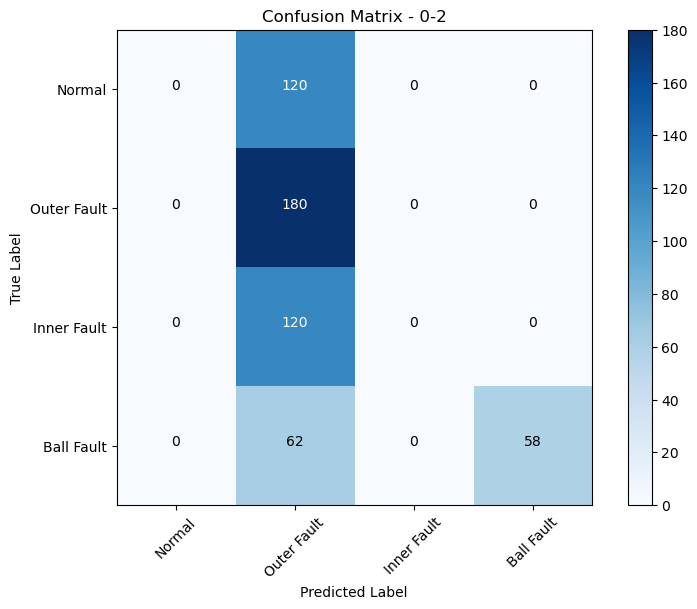


Training transfer task: 0 -> 3
Source domain 0: 480 samples
Target domain 3: 481 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: nan
Epoch [20/200], Loss: nan
Epoch [30/200], Loss: nan
Epoch [40/200], Loss: nan
Epoch [50/200], Loss: nan
Epoch [60/200], Loss: nan
Epoch [70/200], Loss: nan
Epoch [80/200], Loss: nan
Epoch [90/200], Loss: nan
Epoch [100/200], Loss: nan
Epoch [110/200], Loss: nan
Epoch [120/200], Loss: nan
Epoch [130/200], Loss: nan
Epoch [140/200], Loss: nan
Epoch [150/200], Loss: nan
Epoch [160/200], Loss: nan
Epoch [170/200], Loss: nan
Epoch [180/200], Loss: nan
Epoch [190/200], Loss: nan
Epoch [200/200], Loss: nan
Training SAE layer 2...
Epoch [10/200], Loss: nan
Epoch [20/200], Loss: nan
Epoch [30/200], Loss: nan
Epoch [40/200], Loss: nan
Epoch [50/200], Loss: nan
Epoch [60/200], Loss: nan
Epoch [70/200], Loss: nan
Epoch [80/200], Loss: nan
Epoch [90/200], Loss: nan
Epoch [100/200], Loss: nan
Epoch [110/200], Loss: nan
Epoch [120/200],

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


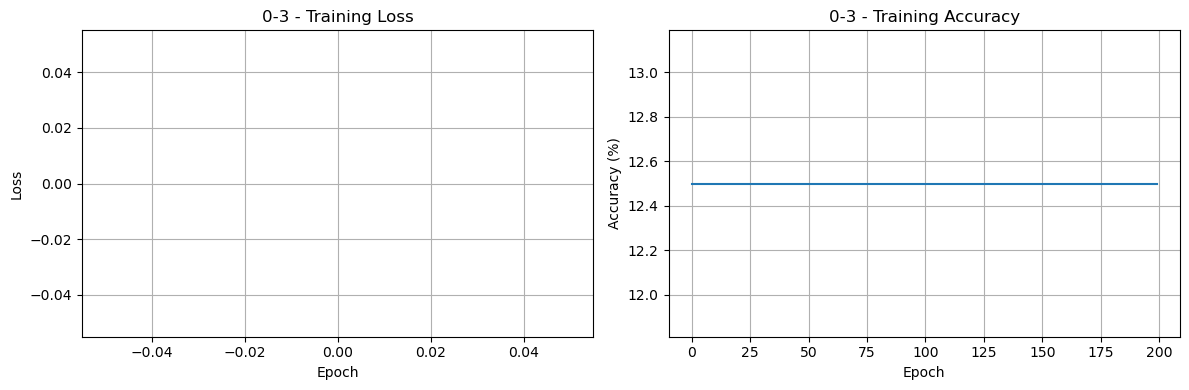

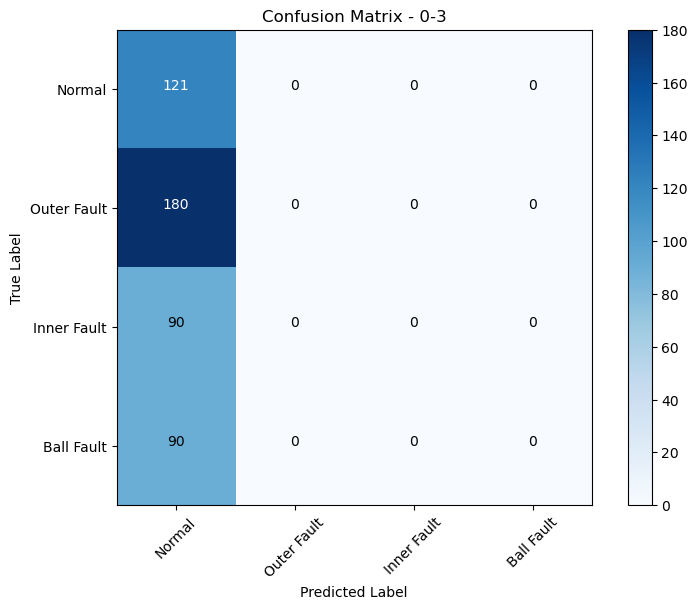


Training transfer task: 1 -> 0
Source domain 1: 540 samples
Target domain 0: 480 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 122.1921
Epoch [20/200], Loss: 92.8897
Epoch [30/200], Loss: 84.1066
Epoch [40/200], Loss: 84.8101
Epoch [50/200], Loss: 84.0804
Epoch [60/200], Loss: 85.4903
Epoch [70/200], Loss: 83.8335
Epoch [80/200], Loss: 80.4165
Epoch [90/200], Loss: 81.2460
Epoch [100/200], Loss: 83.0288
Epoch [110/200], Loss: 81.7880
Epoch [120/200], Loss: 89.0065
Epoch [130/200], Loss: 81.6397
Epoch [140/200], Loss: 82.2248
Epoch [150/200], Loss: 79.2715
Epoch [160/200], Loss: 79.7116
Epoch [170/200], Loss: 75.4146
Epoch [180/200], Loss: 79.5291
Epoch [190/200], Loss: 77.7612
Epoch [200/200], Loss: 72.0521
Training SAE layer 2...
Epoch [10/200], Loss: 26.9749
Epoch [20/200], Loss: 19.7583
Epoch [30/200], Loss: 14.2805
Epoch [40/200], Loss: 10.1516
Epoch [50/200], Loss: 7.0541
Epoch [60/200], Loss: 4.8496
Epoch [70/200], Loss: 3.3188
Epoch [80/200], 

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


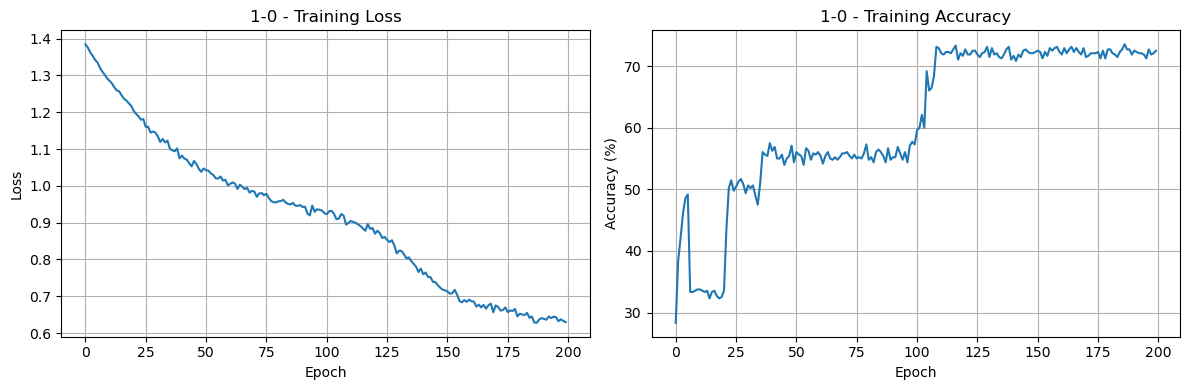

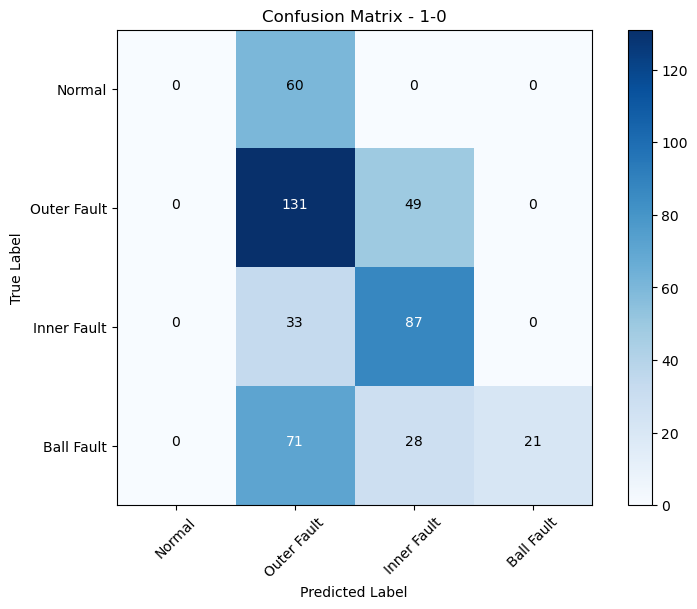


Training transfer task: 1 -> 2
Source domain 1: 540 samples
Target domain 2: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 85.7430
Epoch [20/200], Loss: 64.0943
Epoch [30/200], Loss: 66.2367
Epoch [40/200], Loss: 60.9849
Epoch [50/200], Loss: 61.0434
Epoch [60/200], Loss: 59.0190
Epoch [70/200], Loss: 68.6242
Epoch [80/200], Loss: 59.1131
Epoch [90/200], Loss: 69.0627
Epoch [100/200], Loss: 59.3130
Epoch [110/200], Loss: 59.5945
Epoch [120/200], Loss: 59.6175
Epoch [130/200], Loss: 58.5609
Epoch [140/200], Loss: 72.4072
Epoch [150/200], Loss: 61.2656
Epoch [160/200], Loss: 70.7259
Epoch [170/200], Loss: 59.5496
Epoch [180/200], Loss: 63.8920
Epoch [190/200], Loss: 71.0327
Epoch [200/200], Loss: 58.6803
Training SAE layer 2...
Epoch [10/200], Loss: 42.1702
Epoch [20/200], Loss: 30.5005
Epoch [30/200], Loss: 21.7985
Epoch [40/200], Loss: 15.4810
Epoch [50/200], Loss: 10.9404
Epoch [60/200], Loss: 7.6556
Epoch [70/200], Loss: 5.2882
Epoch [80/200], 

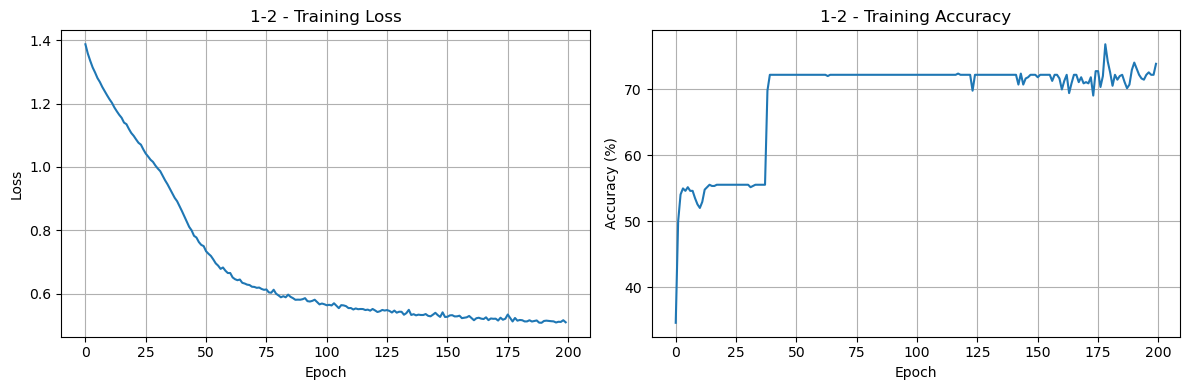

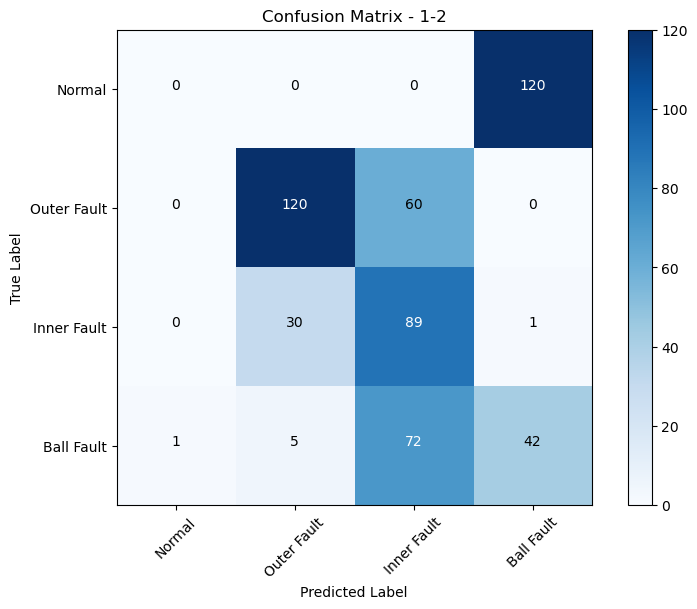


Training transfer task: 1 -> 3
Source domain 1: 540 samples
Target domain 3: 481 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 98.6763
Epoch [20/200], Loss: 75.0736
Epoch [30/200], Loss: 74.1719
Epoch [40/200], Loss: 76.3421
Epoch [50/200], Loss: 70.3645
Epoch [60/200], Loss: 72.2803
Epoch [70/200], Loss: 73.7750
Epoch [80/200], Loss: 76.7810
Epoch [90/200], Loss: 71.6870
Epoch [100/200], Loss: 70.4063
Epoch [110/200], Loss: 73.5914
Epoch [120/200], Loss: 73.0733
Epoch [130/200], Loss: 73.7942
Epoch [140/200], Loss: 76.5788
Epoch [150/200], Loss: 72.4623
Epoch [160/200], Loss: 73.8286
Epoch [170/200], Loss: 73.1328
Epoch [180/200], Loss: 74.3212
Epoch [190/200], Loss: 75.5682
Epoch [200/200], Loss: 84.3407
Training SAE layer 2...
Epoch [10/200], Loss: 25.0993
Epoch [20/200], Loss: 18.1643
Epoch [30/200], Loss: 13.0068
Epoch [40/200], Loss: 9.2742
Epoch [50/200], Loss: 6.4306
Epoch [60/200], Loss: 4.5142
Epoch [70/200], Loss: 3.0482
Epoch [80/200], Lo

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


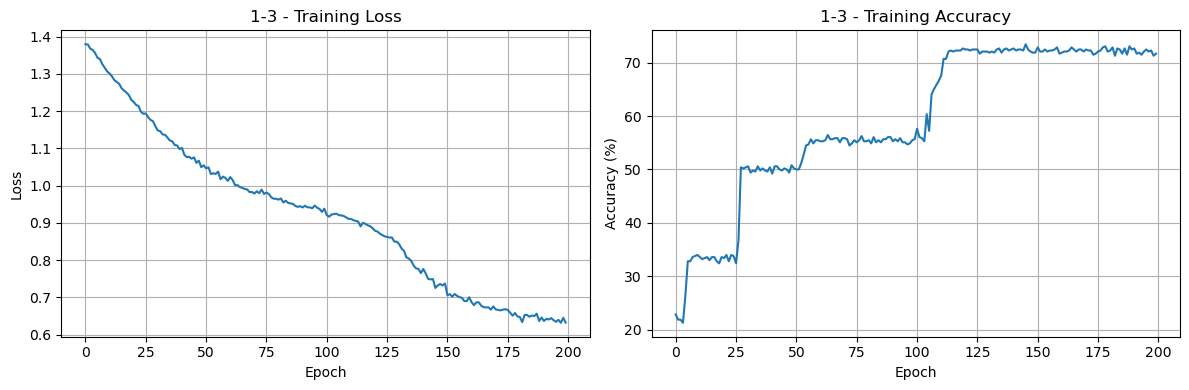

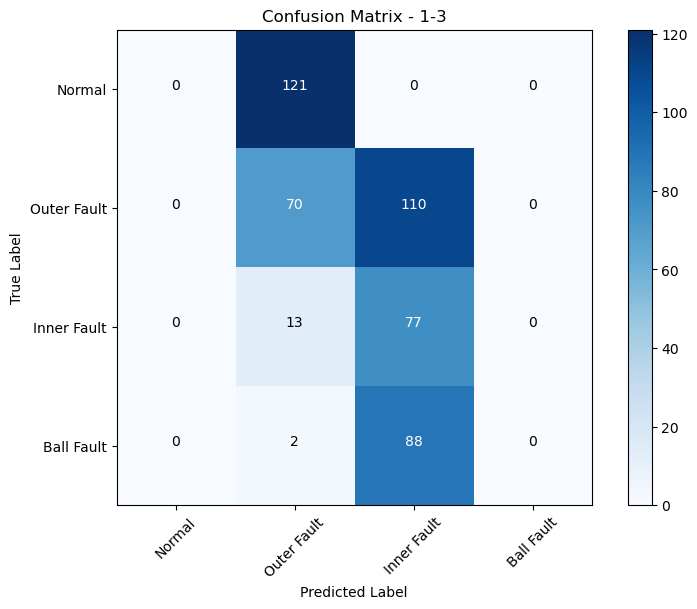


Training transfer task: 2 -> 0
Source domain 2: 540 samples
Target domain 0: 480 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 163.9514
Epoch [20/200], Loss: 66.0631
Epoch [30/200], Loss: 49.5868
Epoch [40/200], Loss: 46.8597
Epoch [50/200], Loss: 45.4937
Epoch [60/200], Loss: 47.3512
Epoch [70/200], Loss: 39.0158
Epoch [80/200], Loss: 47.2877
Epoch [90/200], Loss: 34.0297
Epoch [100/200], Loss: 31.6159
Epoch [110/200], Loss: 39.7112
Epoch [120/200], Loss: 40.6752
Epoch [130/200], Loss: 34.2345
Epoch [140/200], Loss: 32.5998
Epoch [150/200], Loss: 27.3244
Epoch [160/200], Loss: 35.5842
Epoch [170/200], Loss: 33.1282
Epoch [180/200], Loss: 27.6221
Epoch [190/200], Loss: 26.2721
Epoch [200/200], Loss: 33.1578
Training SAE layer 2...
Epoch [10/200], Loss: 37.3228
Epoch [20/200], Loss: 23.6324
Epoch [30/200], Loss: 15.4477
Epoch [40/200], Loss: 10.2346
Epoch [50/200], Loss: 6.8417
Epoch [60/200], Loss: 4.5698
Epoch [70/200], Loss: 3.0311
Epoch [80/200], 

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


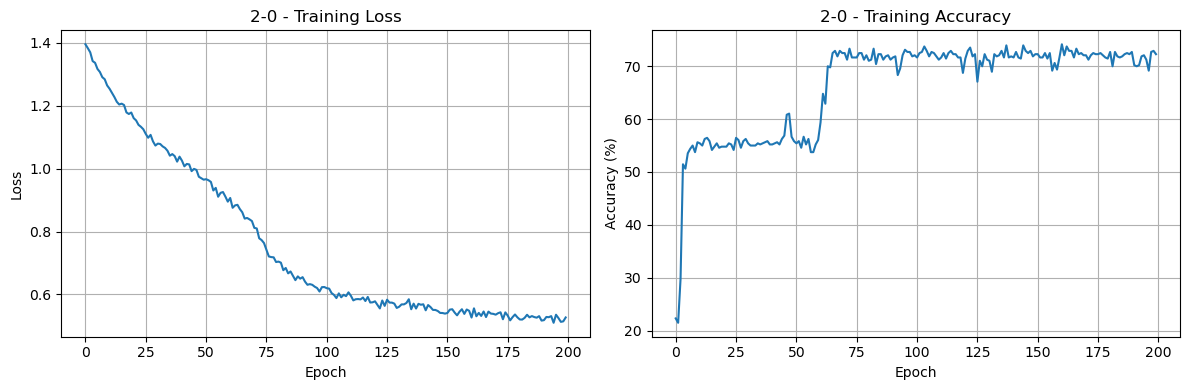

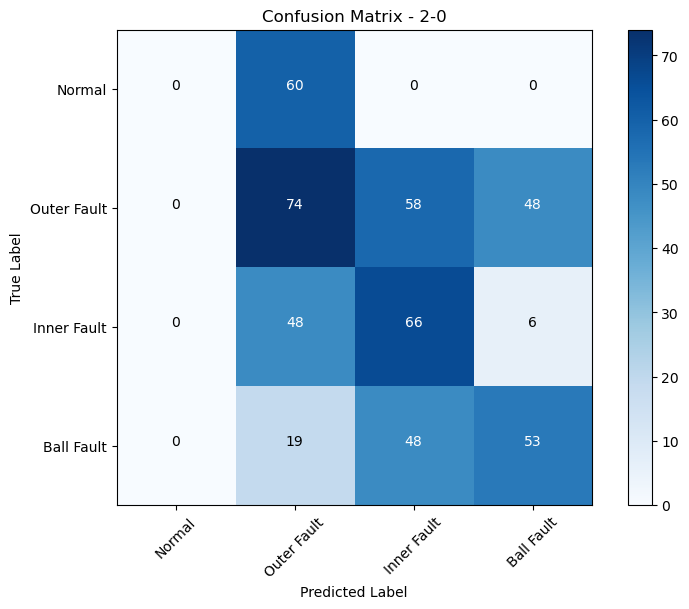


Training transfer task: 2 -> 1
Source domain 2: 540 samples
Target domain 1: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 105.0646
Epoch [20/200], Loss: 81.9667
Epoch [30/200], Loss: 77.3054
Epoch [40/200], Loss: 78.1419
Epoch [50/200], Loss: 83.7567
Epoch [60/200], Loss: 74.4056
Epoch [70/200], Loss: 79.2527
Epoch [80/200], Loss: 73.2436
Epoch [90/200], Loss: 72.4441
Epoch [100/200], Loss: 74.8670
Epoch [110/200], Loss: 75.8250
Epoch [120/200], Loss: 72.5767
Epoch [130/200], Loss: 73.6868
Epoch [140/200], Loss: 74.4292
Epoch [150/200], Loss: 74.4718
Epoch [160/200], Loss: 76.4728
Epoch [170/200], Loss: 74.2297
Epoch [180/200], Loss: 80.8060
Epoch [190/200], Loss: 74.0095
Epoch [200/200], Loss: 75.4899
Training SAE layer 2...
Epoch [10/200], Loss: 26.7160
Epoch [20/200], Loss: 19.3480
Epoch [30/200], Loss: 13.8247
Epoch [40/200], Loss: 9.5832
Epoch [50/200], Loss: 6.6357
Epoch [60/200], Loss: 4.4423
Epoch [70/200], Loss: 2.9753
Epoch [80/200], L

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


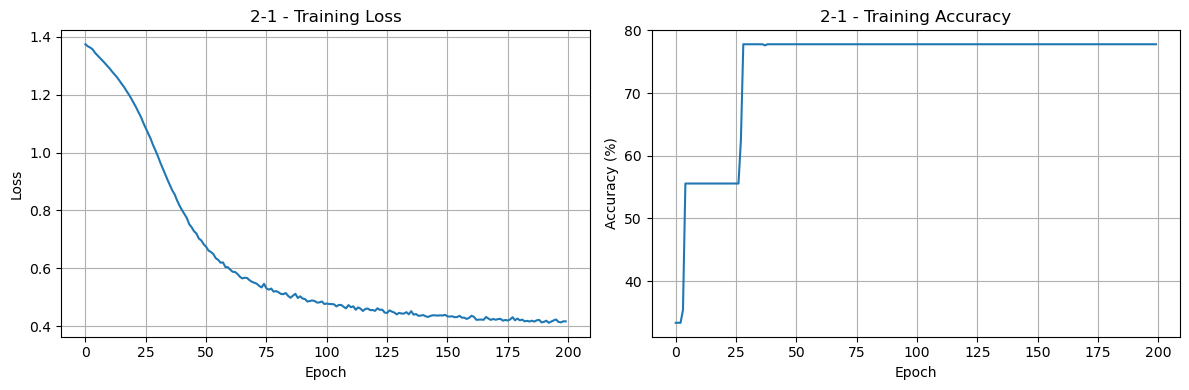

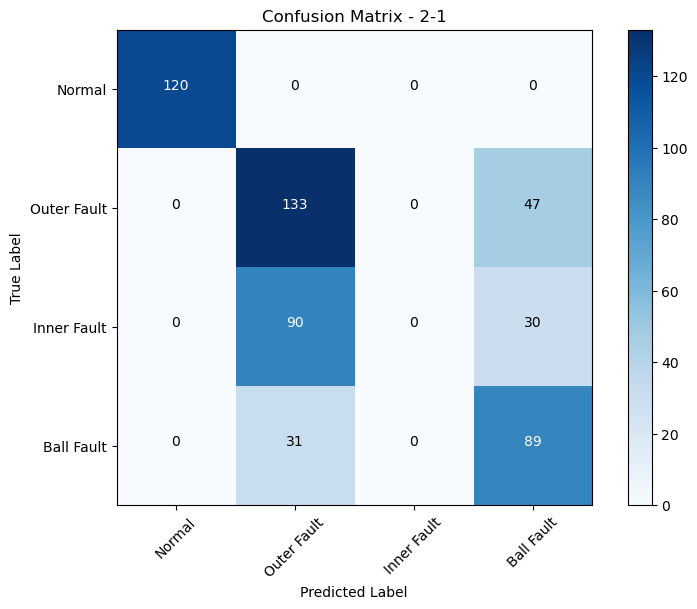


Training transfer task: 2 -> 3
Source domain 2: 540 samples
Target domain 3: 481 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 114.5075
Epoch [20/200], Loss: 75.1720
Epoch [30/200], Loss: 52.7845
Epoch [40/200], Loss: 50.6241
Epoch [50/200], Loss: 50.6798
Epoch [60/200], Loss: 52.2399
Epoch [70/200], Loss: 55.0399
Epoch [80/200], Loss: 49.3033
Epoch [90/200], Loss: 58.1114
Epoch [100/200], Loss: 46.4685
Epoch [110/200], Loss: 43.4659
Epoch [120/200], Loss: 44.9847
Epoch [130/200], Loss: 38.3548
Epoch [140/200], Loss: 45.9142
Epoch [150/200], Loss: 46.2301
Epoch [160/200], Loss: 52.6579
Epoch [170/200], Loss: 42.6991
Epoch [180/200], Loss: 50.6298
Epoch [190/200], Loss: 54.2808
Epoch [200/200], Loss: 61.1257
Training SAE layer 2...
Epoch [10/200], Loss: 41.5067
Epoch [20/200], Loss: 28.2981
Epoch [30/200], Loss: 19.4851
Epoch [40/200], Loss: 13.5154
Epoch [50/200], Loss: 9.3983
Epoch [60/200], Loss: 6.5321
Epoch [70/200], Loss: 4.5426
Epoch [80/200], 

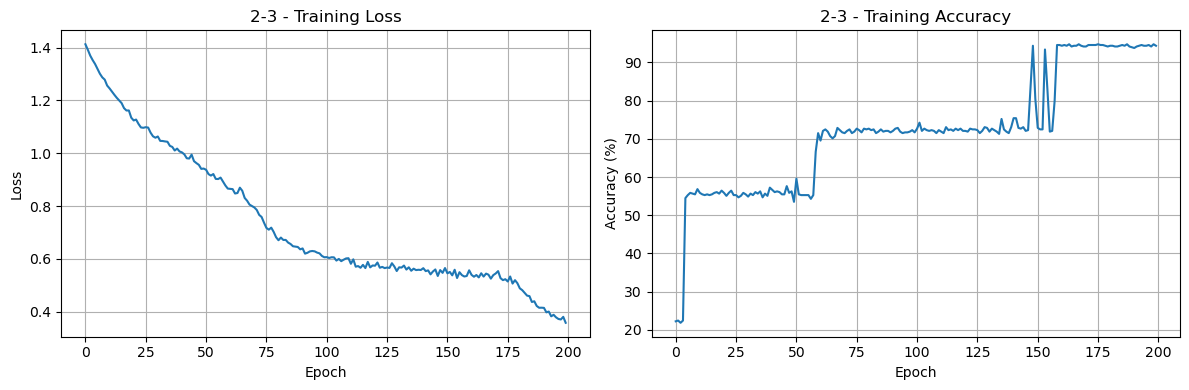

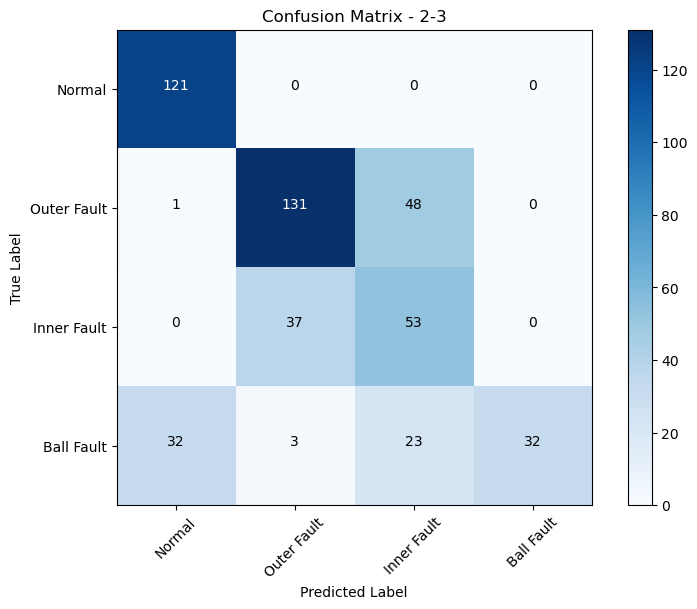


Training transfer task: 3 -> 0
Source domain 3: 481 samples
Target domain 0: 480 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: nan
Epoch [20/200], Loss: nan
Epoch [30/200], Loss: nan
Epoch [40/200], Loss: nan
Epoch [50/200], Loss: nan
Epoch [60/200], Loss: nan
Epoch [70/200], Loss: nan
Epoch [80/200], Loss: nan
Epoch [90/200], Loss: nan
Epoch [100/200], Loss: nan
Epoch [110/200], Loss: nan
Epoch [120/200], Loss: nan
Epoch [130/200], Loss: nan
Epoch [140/200], Loss: nan
Epoch [150/200], Loss: nan
Epoch [160/200], Loss: nan
Epoch [170/200], Loss: nan
Epoch [180/200], Loss: nan
Epoch [190/200], Loss: nan
Epoch [200/200], Loss: nan
Training SAE layer 2...
Epoch [10/200], Loss: nan
Epoch [20/200], Loss: nan
Epoch [30/200], Loss: nan
Epoch [40/200], Loss: nan
Epoch [50/200], Loss: nan
Epoch [60/200], Loss: nan
Epoch [70/200], Loss: nan
Epoch [80/200], Loss: nan
Epoch [90/200], Loss: nan
Epoch [100/200], Loss: nan
Epoch [110/200], Loss: nan
Epoch [120/200],

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


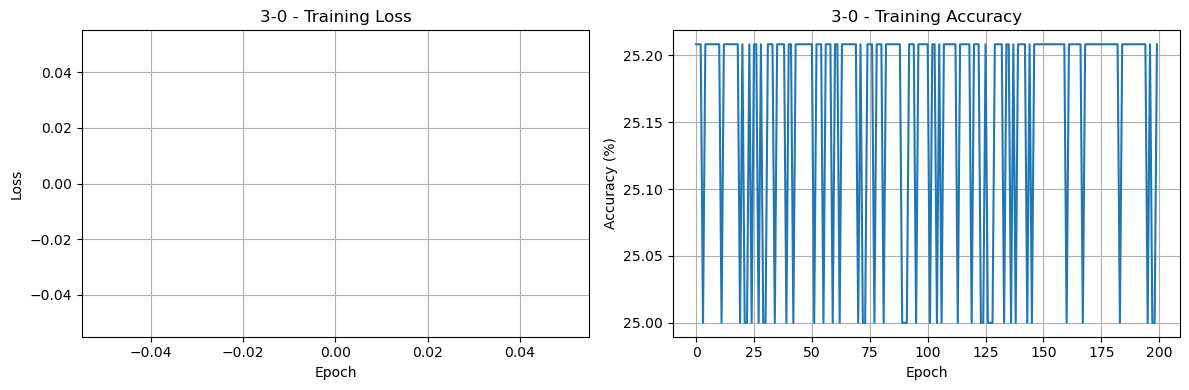

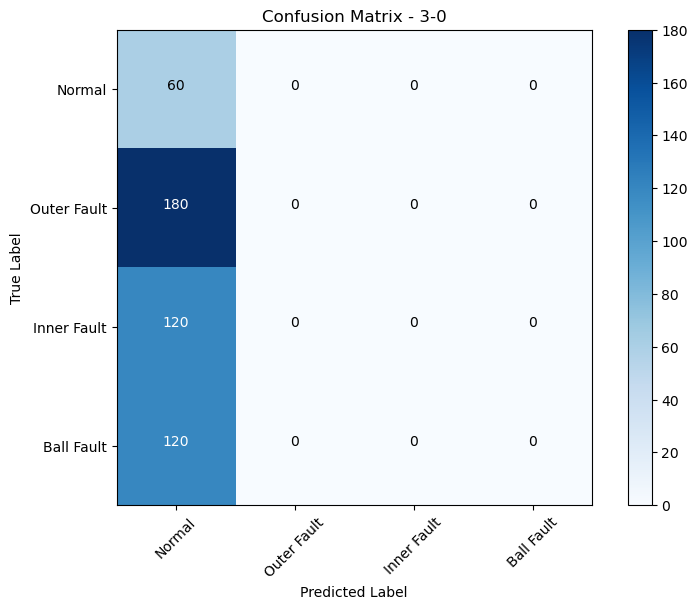


Training transfer task: 3 -> 1
Source domain 3: 481 samples
Target domain 1: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 87.8098
Epoch [20/200], Loss: 77.2687
Epoch [30/200], Loss: 71.4847
Epoch [40/200], Loss: 68.9003
Epoch [50/200], Loss: 86.3900
Epoch [60/200], Loss: 70.8863
Epoch [70/200], Loss: 65.8833
Epoch [80/200], Loss: 72.6935
Epoch [90/200], Loss: 66.2324
Epoch [100/200], Loss: 76.1436
Epoch [110/200], Loss: 68.7114
Epoch [120/200], Loss: 75.9594
Epoch [130/200], Loss: 67.2758
Epoch [140/200], Loss: 69.9774
Epoch [150/200], Loss: 71.0727
Epoch [160/200], Loss: 80.8127
Epoch [170/200], Loss: 71.1103
Epoch [180/200], Loss: 69.7890
Epoch [190/200], Loss: 67.3079
Epoch [200/200], Loss: 67.3298
Training SAE layer 2...
Epoch [10/200], Loss: 40.9084
Epoch [20/200], Loss: 30.1405
Epoch [30/200], Loss: 22.0609
Epoch [40/200], Loss: 16.0866
Epoch [50/200], Loss: 11.6081
Epoch [60/200], Loss: 8.3161
Epoch [70/200], Loss: 5.9031
Epoch [80/200], 

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


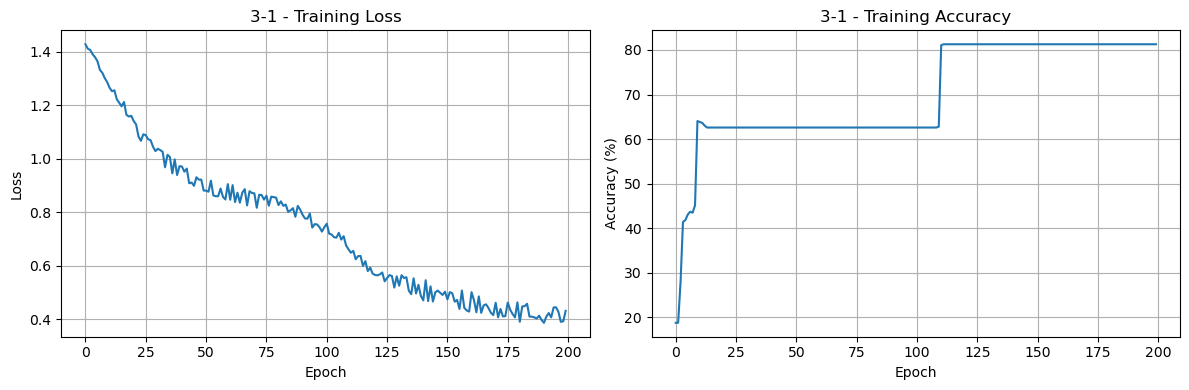

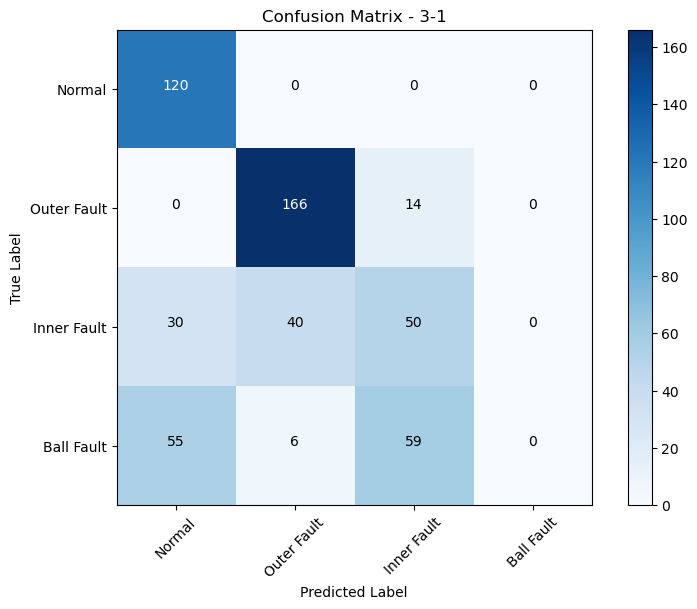


Training transfer task: 3 -> 2
Source domain 3: 481 samples
Target domain 2: 540 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/200], Loss: 95.3444
Epoch [20/200], Loss: 62.3314
Epoch [30/200], Loss: 54.9619
Epoch [40/200], Loss: 46.6866
Epoch [50/200], Loss: 43.9960
Epoch [60/200], Loss: 44.2692
Epoch [70/200], Loss: 53.6649
Epoch [80/200], Loss: 53.3898
Epoch [90/200], Loss: 59.3805
Epoch [100/200], Loss: 46.4144
Epoch [110/200], Loss: 43.6826
Epoch [120/200], Loss: 46.8774
Epoch [130/200], Loss: 52.9051
Epoch [140/200], Loss: 50.8419
Epoch [150/200], Loss: 48.1289
Epoch [160/200], Loss: 53.3215
Epoch [170/200], Loss: 41.2696
Epoch [180/200], Loss: 49.3473
Epoch [190/200], Loss: 41.1164
Epoch [200/200], Loss: 49.5130
Training SAE layer 2...
Epoch [10/200], Loss: 44.9776
Epoch [20/200], Loss: 33.0906
Epoch [30/200], Loss: 24.0938
Epoch [40/200], Loss: 17.4243
Epoch [50/200], Loss: 12.5590
Epoch [60/200], Loss: 8.9757
Epoch [70/200], Loss: 6.3965
Epoch [80/200], 

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


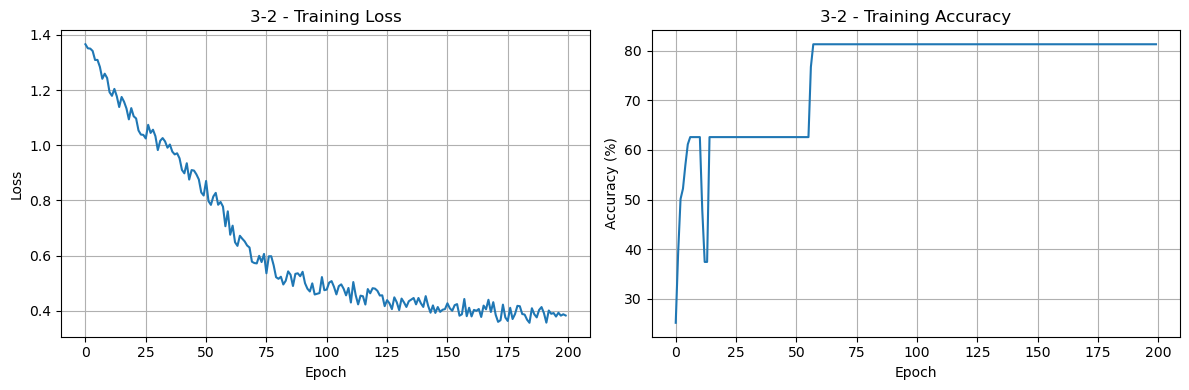

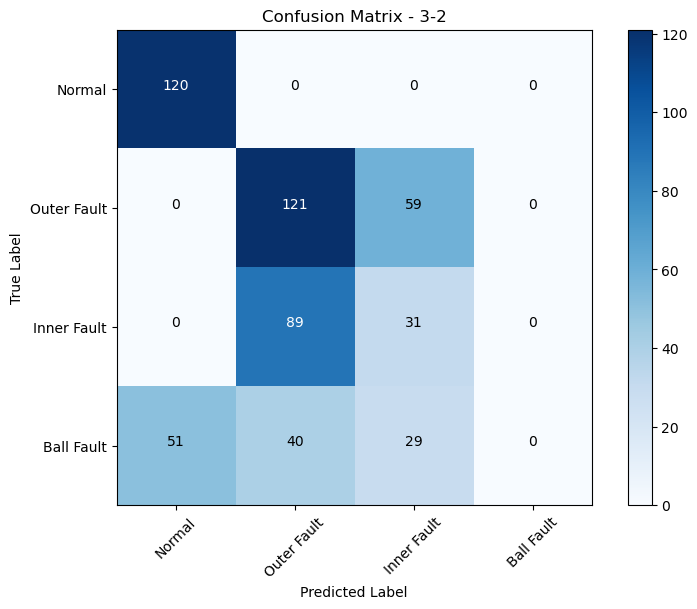


FINAL TRANSFER LEARNING RESULTS
0-1: 0.4222
0-2: 0.4407
0-3: 0.2516
1-0: 0.4979
1-2: 0.4648
1-3: 0.3056
2-0: 0.4021
2-1: 0.6333
2-3: 0.7006
3-0: 0.1250
3-1: 0.6222
3-2: 0.5037

Best transfer task: 2-3 (Accuracy: 0.7006)
Worst transfer task: 3-0 (Accuracy: 0.1250)
Best model saved from task: 2-3


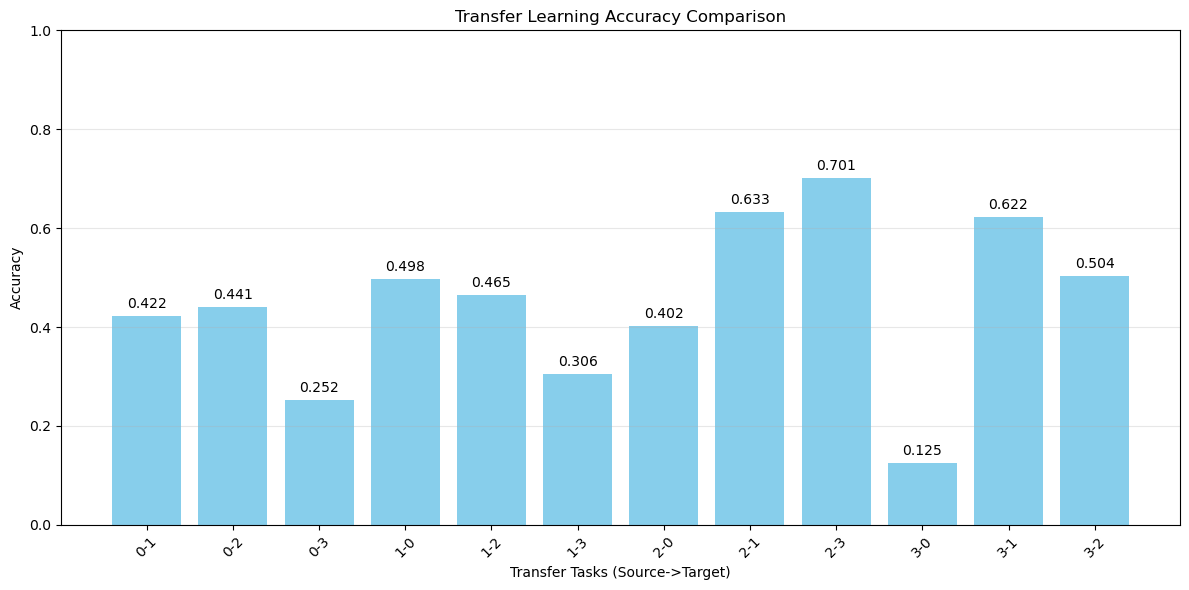

In [9]:
# 主执行流程
def main():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据
    print("Loading bearing data...")
    data_path = r"D:\deskbook\科研\数据集\cwru\data"  # 修改为您的数据路径
    datasets = load_bearing_data(data_path)

    if not datasets:
        print("No data loaded! Please check your data path and file structure.")
        return

    # 数据预处理
    print("Preprocessing data...")
    processed_datasets = preprocess_data(datasets)

    # 定义迁移任务 (源域-目标域)
    transfer_tasks = [
        ('0', '1'), ('0', '2'), ('0', '3'),
        ('1', '0'), ('1', '2'), ('1', '3'),
        ('2', '0'), ('2', '1'), ('2', '3'),
        ('3', '0'), ('3', '1'), ('3', '2')
    ]

    results = {}
    class_names = ['Normal', 'Outer Fault', 'Inner Fault', 'Ball Fault']

    for source_load, target_load in transfer_tasks:
        if source_load not in processed_datasets or target_load not in processed_datasets:
            print(f"Skipping {source_load}->{target_load}: data not available")
            continue

        print(f"\n{'='*50}")
        print(f"Training transfer task: {source_load} -> {target_load}")
        print(f"{'='*50}")

        source_data = processed_datasets[source_load]
        target_data = processed_datasets[target_load]

        print(f"Source domain {source_load}: {source_data['data'].shape[0]} samples")
        print(f"Target domain {target_load}: {target_data['data'].shape[0]} samples")

        # 训练DTL模型
        model, history = train_dtl_model(source_data, target_data, device=device)

        # 评估模型
        accuracy, cm, predictions, true_labels, probabilities = evaluate_model(model, target_data, device=device)

        results[f"{source_load}-{target_load}"] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'history': history,
            'model': model,
            'predictions': predictions,
            'true_labels': true_labels
        }

        print(f"\nTransfer {source_load}->{target_load}: Accuracy = {accuracy:.4f}")

        # 输出分类报告
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=class_names))

        # 绘制训练历史和混淆矩阵
        plot_training_history(history, f"{source_load}-{target_load}")
        plot_confusion_matrix(cm, class_names, f"{source_load}-{target_load}")

    # 输出最终结果
    print("\n" + "="*60)
    print("FINAL TRANSFER LEARNING RESULTS")
    print("="*60)

    for task, result in results.items():
        print(f"{task}: {result['accuracy']:.4f}")

    # 找出最佳模型
    if results:
        best_task = max(results, key=lambda x: results[x]['accuracy'])
        best_accuracy = results[best_task]['accuracy']
        worst_task = min(results, key=lambda x: results[x]['accuracy'])
        worst_accuracy = results[worst_task]['accuracy']

        print(f"\nBest transfer task: {best_task} (Accuracy: {best_accuracy:.4f})")
        print(f"Worst transfer task: {worst_task} (Accuracy: {worst_accuracy:.4f})")

        # 保存最佳模型
        best_model = results[best_task]['model']
        torch.save(best_model.state_dict(), 'best_dtl_model.pth')
        print(f"Best model saved from task: {best_task}")

        # 绘制所有任务的准确率比较
        tasks = list(results.keys())
        accuracies = [results[task]['accuracy'] for task in tasks]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(tasks, accuracies, color='skyblue')
        plt.title('Transfer Learning Accuracy Comparison')
        plt.xlabel('Transfer Tasks (Source->Target)')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.ylim(0, 1.0)
        plt.grid(axis='y', alpha=0.3)

        # 在柱状图上显示数值
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{accuracy:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('transfer_learning_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    main()